In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings(action='ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'

import time
from tqdm.notebook import tqdm

import datetime
from datetime import timedelta

import re

In [2]:
data = pd.read_excel('data_v2.xlsx')
del data['Unnamed: 0']

In [3]:
data = data[data['발생지']!='타시도확진자'] # 확인중 환자
data = data[data['발생지']!='해외']
data = data[data['발생지']!='확인중']
data = data[data['발생지']!='확인 중']

In [4]:
data = data[data['발생지']!='성북구사랑제일교회']
data = data[data['발생지']!='기타확진자']

In [5]:
data.columns

Index(['환자번호', '날짜', '거주지', '퇴원현황', '세부정보', '발생지', '감염자', '그림번호', '누적확진자',
       '피해자수', '감염유형', '시간축'],
      dtype='object')

In [6]:
data['발생지'].value_counts()

이태원클럽        139
리치웨이         119
용인시우리제일교회     74
구로구콜센터        61
광화문집회         56
            ... 
쇼핑몰            1
강동구확진자         1
6727           1
관악구김혜근의원       1
8881           1
Name: 발생지, Length: 208, dtype: int64

In [7]:
data['month'] = data['날짜'].apply(lambda x : x.month)
data['day'] = data['날짜'].apply(lambda x : x.day)

In [8]:
data = data.reset_index(drop=True)

- Histogram of cumulative infectee

In [9]:
import chart_studio
chart_studio.tools.set_credentials_file(username='username', api_key='api_key')
import chart_studio.plotly as py
import plotly.express as px

In [10]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
rc('font',family = 'Malgun Gothic')
plt.style.use('ggplot')

In [8]:
df = pd.pivot_table(data,index='발생지',values='피해자수').sort_values(by='피해자수',ascending=False).reset_index()
df['발생지'] = df['발생지'].apply(lambda x : str(x))

In [9]:
plt.rcParams["figure.figsize"] = (15,4)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

<BarContainer object of 210 artists>

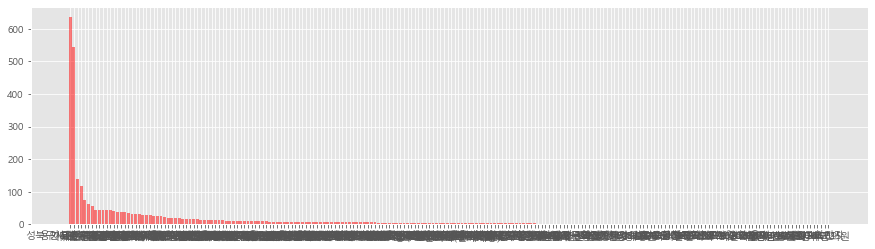

In [11]:
plt.bar(df['발생지'], df['피해자수'], color='red', alpha=0.5)

In [12]:
fig = px.line(df, x="발생지", y="피해자수")
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
                  yaxis_showgrid=False,width=1000, height=600,
                  title='확진자 빈도수')

- 636(성북구 사랑제일교회) -> 139 (이태원)
- 139(이태원               -> 74(용인시 우리제일교회)

- 시간대별 시기조정

In [14]:
def SnapShot(data, start_month, start_day , time_delta):
    
    i = [0,0,1,1]
    j = [0,1,0,1]
    
    start = pd.to_datetime("2020-"+str(start_month).zfill(2)+"-"+str(start_day))  # 시작날짜 초기화
    end = start + timedelta(days=time_delta) # timedelta 더해준 마지막날짜
    
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15.5, 7.5), sharex=True)
    for i,j in zip(i,j):
        df = data[ data['날짜'] >= start][data['날짜']<end].reset_index(drop=True) # 시작날짜 ~ 종료날짜 해당하는 DF 추출
    
        axes[i,j].scatter(df['날짜'],df['누적확진자'],c=df['감염자'])
        # start = end  # 종료날짜다음날부터를 시작날짜로 재설정
        end = end + timedelta(days=time_delta) # 종료날짜 재설정


    plt.show()
    return df

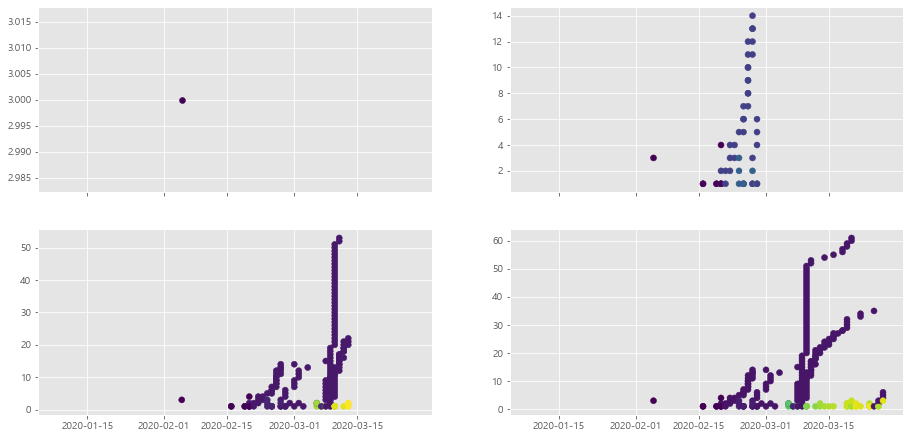

In [58]:
a = SnapShot(data,start_month = 2, start_day =1, time_delta = 14)

In [28]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()

In [29]:
num = list(range(500,650))
num = str(num)

In [33]:
df = data[data['누적확진자']<=10]
df = df[df['month']<=5][df['day']<31]

In [34]:
df['환자번호'] = scl.fit_transform(np.array(df['환자번호']).reshape(-1,1))

In [35]:
fig = px.line(df, x="날짜", y="누적확진자")
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
                  yaxis_showgrid=False,width=1000, height=600,
                  title='확진자 빈도수')

--------------------

### Central metric

- 연결 중심성 (Degree centality)
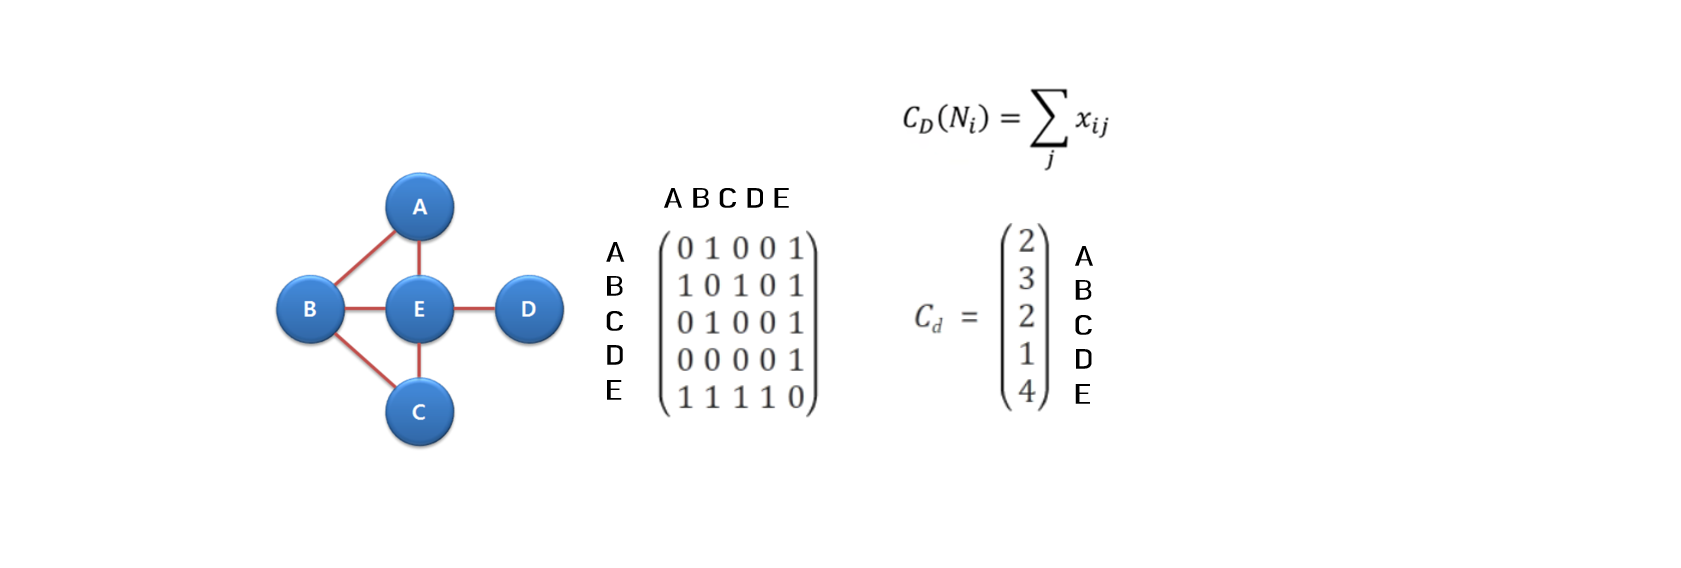

- 매개 중심성 (Betweeness centrality)
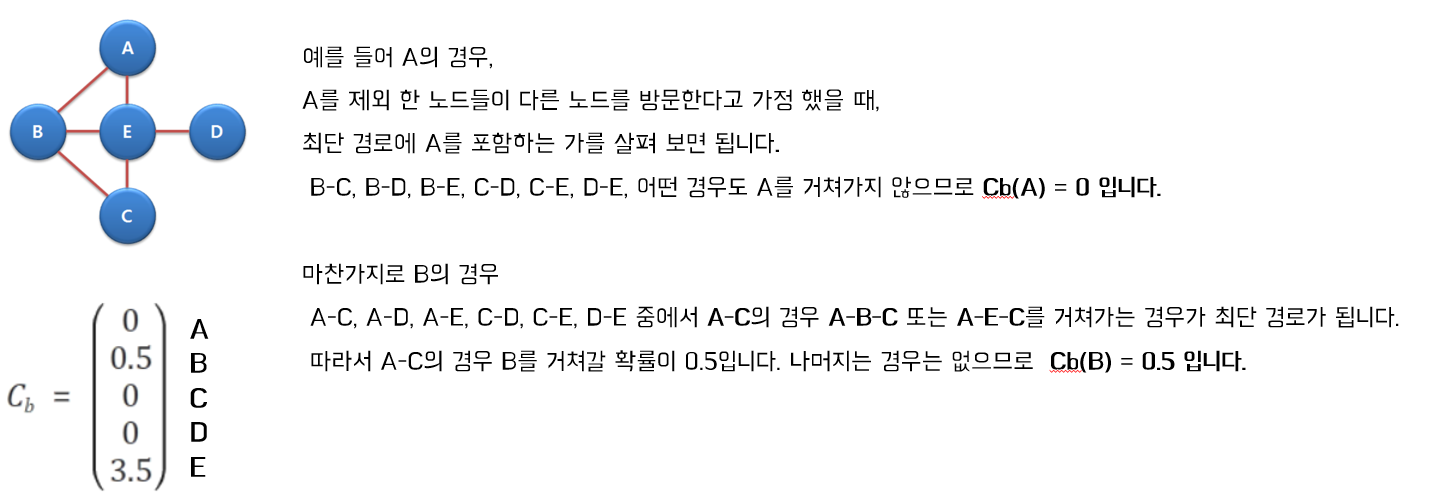

- 근접 중심성(Closeness centrality)
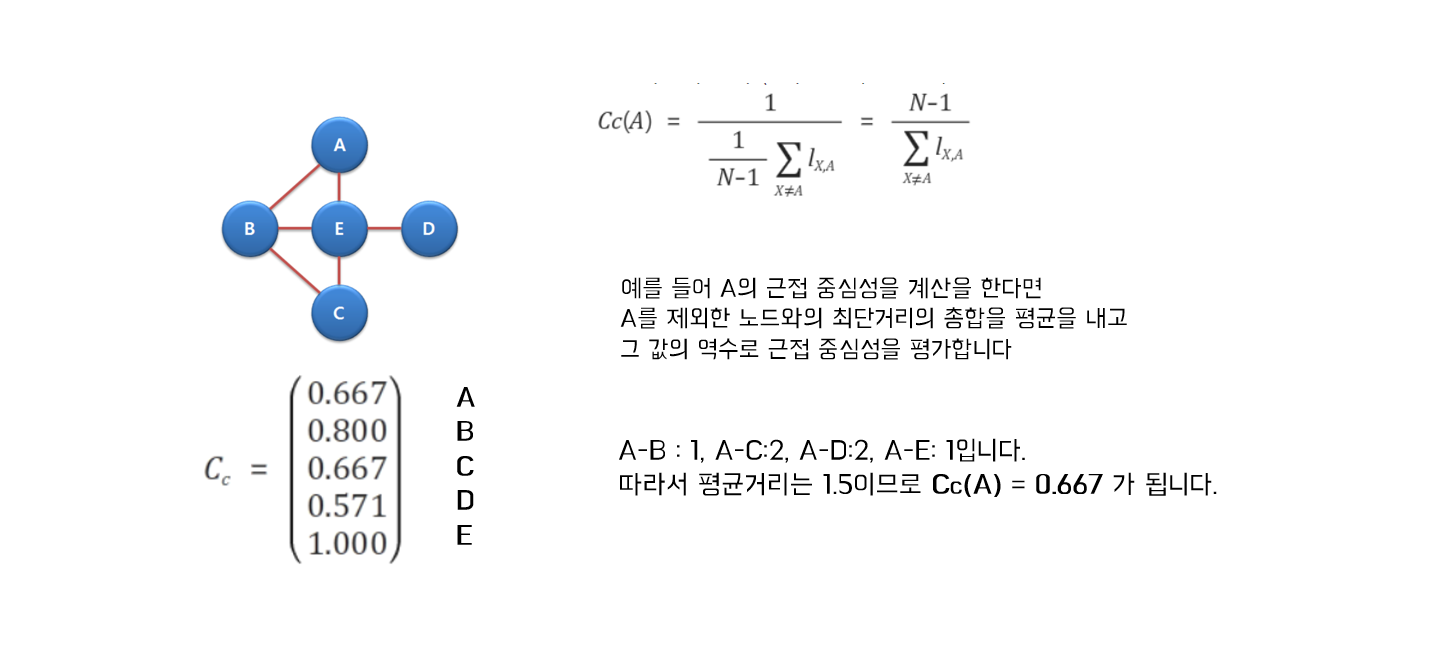

- 고유 중심성(Eigenvector centrality)
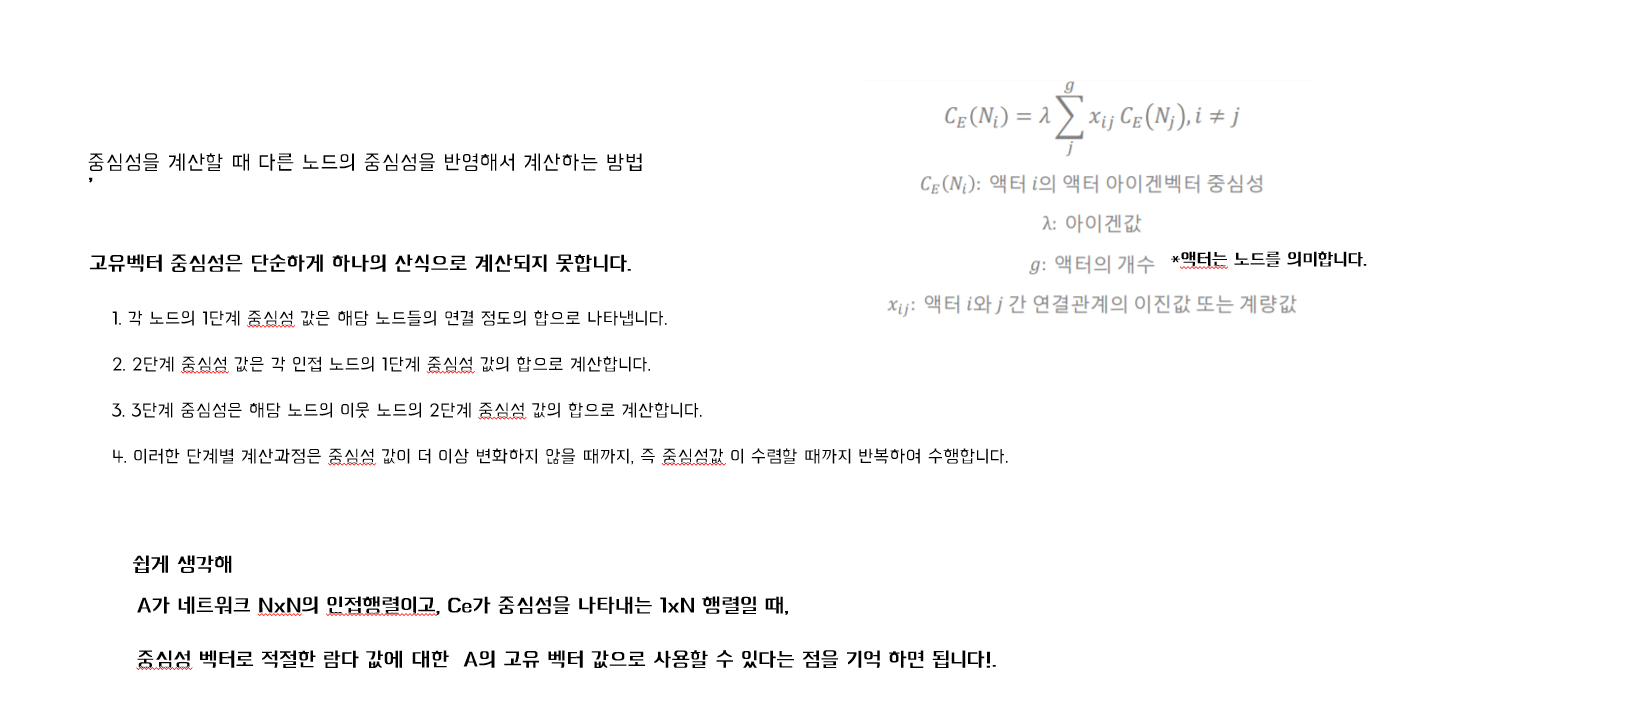

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

- 시간대별 네트워크

In [14]:
def TVG_CEN(data, start_month, start_day , time_delta, method):
    
    # 중심성지표 함수
    
    def return_centralities_as_dict(input_g):
        # weighted degree centrality를 딕셔너리로 리턴
        def return_weighted_degree_centrality(input_g, normalized=False):
            w_d_centrality = {n:0.0 for n in input_g.nodes()}
            for u, v, d in input_g.edges(data=True):
                w_d_centrality[u]+=d['weight']
                w_d_centrality[v]+=d['weight']
            if normalized==True:
                weighted_sum = sum(w_d_centrality.values())
                return {k:v/weighted_sum for k, v in w_d_centrality.items()}
            else:
                return w_d_centrality
        def return_closeness_centrality(input_g):
            new_g_with_distance = input_g.copy()
            for u,v,d in new_g_with_distance.edges(data=True):
                if 'distance' not in d:
                    d['distance'] = 1.0/d['weight']
            return nx.closeness_centrality(new_g_with_distance, distance='distance')
        def return_betweenness_centrality(input_g):
            return nx.betweenness_centrality(input_g, weight='weight')
        def return_pagerank(input_g):
            return nx.pagerank(input_g, weight='weight')
        return {
            'weighted_deg':return_weighted_degree_centrality(input_g),
            'closeness_cent':return_closeness_centrality(input_g), 
            'betweeness_cent':return_betweenness_centrality(input_g),
            'pagerank':return_pagerank(input_g)
        }
    
    # 그래프 틀 만들기
    
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15.5, 7.5), sharex=True)
    ax = axes.flatten()
    start = pd.to_datetime("2020-"+str(start_month).zfill(2)+"-"+str(start_day))  # 시작날짜 초기화
    end = start + timedelta(days=time_delta) # timedelta 더해준 마지막날짜
    
    output = pd.DataFrame() # 시기별 중심성지표 빈 데이터프레임 만들기
    
    for i in range(4):
        
        # 그래프 그리기
        
        df = data[ data['날짜'] >= start][data['날짜']<end].reset_index(drop=True) # 시작날짜 ~ 종료날짜 해당하는 DF 추출
        edges = []   # Empty Edge list
        
        for j in range(len(df)):
            edges.append((str(df['감염자'][j]),str(df['환자번호'][j]),1)) # Edge 만들기
            
        G = nx.Graph() # 그래프 생성
        G.add_weighted_edges_from(edges) # 그래프 안에서 Edge ㅇ녀결
        nx.draw_networkx(G, ax=ax[i],with_labels=False,cmap=plt.cm.Blues) # Subplot에 날짜 구하기
        
        # 시기별 중심성지표 데이터프레임 만들기
        
        nodes= []
        values= []
        for key, value in return_centralities_as_dict(G).items():
            newdict = value
            for key2,value2 in newdict.items():
                nodes.append(key2)
                values.append(value2)


        length = int(len(nodes)/4)
        Degree = values[:length*1]
        Closeness = values[length*1:length*2]
        Betweeness = values[length*2:length*3]
        Pagerank = values[length*3 :]
        nodes = nodes[:length*1]
        time = []
        
        for k in range(length):
            time.append(end)

        total = pd.DataFrame({'Node' : nodes,
                              'Degree' : Degree,
                              'Closness' : Closeness,
                              'Betweeness' : Betweeness,
                              'Pagerank' : Pagerank,
                              'Time' :time})
        
        output = pd.concat([output,total])
        if method == "Separate":
            start = end  # 종료날짜다음날부터를 시작날짜로 재설정
            end = end + timedelta(days=time_delta) # 종료날짜 재설정
        else:
            end = end + timedelta(days=time_delta) # 종료날짜 재설정

    return output

- 시간대별 Density , Average_coefficient

In [11]:
def Measure(data, start_month, start_day , time_delta,rep):  
   
    start = pd.to_datetime("2020-"+str(start_month).zfill(2)+"-"+str(start_day))  # 시작날짜 초기화
    
    output = pd.DataFrame() # 시기별 중심성지표 빈 데이터프레임 만들기
    
    def density(graph):
        if len(graph.edges()) <2:
            return 0
        else:
            return len(graph.edges()) / (len(graph.nodes()) * (len(graph.nodes()) - 1))
    
    def AVG_COEF(graph):
        nodes = list(G.nodes())
        edges = list(G.edges())
        
        if len(nodes) < 2:
            return 0 
        else:
            deg = []  # deg()
            for n in nodes:
                a = []
                for i in edges:
                    if i[0] == n:
                        a.append(i[1])   # 각 노드에 대한 degree 구하기
                    else:
                        continue

                if len(a) < 2 :
                    deg.append(0)
                else:
                    deg.append(len(edges) / (len(a)*(len(a)-1)))
                
            return sum(deg) / len(nodes)

            
    
    date = []   
    dense = []
    avg_coef =[]
    for i in range(rep):
        
        df = data[ data['날짜'] == start].reset_index(drop=True) # 시작날짜 ~ 종료날짜 해당하는 DF 추출
        edges = []   # Empty Edge list
        for j in range(len(df)):
            edges.append((str(df['감염자'][j]),str(df['환자번호'][j]),1)) # Edge 만들기
            
        G = nx.Graph() # 그래프 생성
        G.add_weighted_edges_from(edges) # 그래프 안에서 Edge ㅇ녀결
        
        date.append(start)
        dense.append(density(G))
        avg_coef.append(AVG_COEF(G))
        
        start = start + timedelta(days=time_delta)
        
    output = pd.DataFrame({'Date' : date , 'Density' : dense, 'AVG_COEF' : avg_coef})

    return output

In [35]:
start = pd.to_datetime("2020-"+str(3).zfill(2)+"-"+str(7))

In [36]:
def density(graph):
    return len(graph.edges()) / (len(graph.nodes()) * (len(graph.nodes()) - 1))

In [37]:
date = []   
dense = []

In [38]:
df = data[ data['날짜'] == start].reset_index(drop=True) # 시작날짜 ~ 종료날짜 해당하는 DF 추출
edges = []   # Empty Edge list
for j in range(len(df)):
    edges.append((str(df['감염자'][j]),str(df['환자번호'][j]),1)) # Edge 만들기

G = nx.Graph() # 그래프 생성
G.add_weighted_edges_from(edges) # 그래프 안에서 Edge ㅇ녀결


In [39]:
deg = []
nodes = list(G.nodes())
edges = list(G.edges())

In [42]:
nodes
edges

['6921', '7011', '6937', '935', '6999']

[('6921', '7011'), ('6921', '6937'), ('935', '6999')]

In [44]:
nodes = list(G.nodes())
edges = list(G.edges())
deg = []
modular = []
for n in nodes:
    a = []
    for i in edges:
        if i[0] == n :
            a.append(i[1])   # 각 노드에 대한 degree 구하기
        elif i[1] == n:
            a.append(i[0])
        else:
            continue

    deg.append(len(a))

for i in range(len(deg)):
    for j in range(i+1,len(deg)):
        modular.append(deg[i]*deg[j] / (2*len(edges)))

In [56]:
deg
len(edges)
np.mean(modular)
len(deg)
deg[1]
sum(modular) / len(modular)

[2, 1, 1, 1, 1]

3

0.2333333333333333

5

1

0.2333333333333333

In [137]:
for n in nodes:
    a = []
    for i in edges:
        if i[0] == n:
            a.append(i[1])   # 각 노드에 대한 degree 구하기
        else:
            continue
        
    if len(a) < 2 :
        deg.append(0)
    else:
        deg.append(len(edges) / (len(a)*(len(a)-1)))

In [139]:
sum(deg) / len(nodes)

0.1111111111111111

In [89]:
G = nx.Graph()
for edge in Edge.objects.all():
    G.add_edge(edge.from_location, edge.to_location, weight=edge.distance)

networkx.classes.reportviews.NodeView

In [52]:
a = Measure(data,start_month = 2, start_day =1, time_delta = 1 , rep = 250)
# 3월1일 ~ 3월 7일
# 3월8일 ~ 3월15일
# 3월16일 ~ 3월 22일
# 3월23일 ~ 3월30일

In [53]:
a

Date  Density  AVG_COEF
0   2020-02-01      0.0       0.0
1   2020-02-02      0.0       0.0
2   2020-02-03      0.0       0.0
3   2020-02-04      0.0       0.0
4   2020-02-05      0.0       0.0
..         ...      ...       ...
245 2020-10-03      0.0       0.0
246 2020-10-04      0.0       0.0
247 2020-10-05      0.0       0.0
248 2020-10-06      0.0       0.0
249 2020-10-07      0.0       0.0

[250 rows x 3 columns]

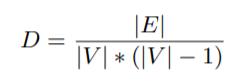

In [54]:
data.head()

index  환자번호         날짜  거주지 퇴원현황          세부정보 발생지  감염자  그림번호  누적확진자  피해자수  \
0      0     6 2020-01-30  종로구   퇴원  이동경로 공개기간 경과   3    3    23      1     1   
1      1    11 2020-01-31  종로구   퇴원  이동경로 공개기간 경과   6    6    18      1     4   
2      2    10 2020-01-31  종로구   퇴원  이동경로 공개기간 경과   6    6    18      2     4   
3      3     9 2020-01-31  성북구   퇴원  이동경로 공개기간 경과   5    5    22      1     1   
4      4    21 2020-02-05  성북구   퇴원  이동경로 공개기간 경과   6    6    18      3     4   

         감염유형  시간축  month  day  
0    Personal  130      1   30  
1  SmallGroup  131      1   31  
2  SmallGroup  131      1   31  
3    Personal  131      1   31  
4  SmallGroup  205      2    5

In [55]:
data[data['피해자수']< 10 ]

index   환자번호         날짜  거주지 퇴원현황          세부정보         발생지  감염자  그림번호  \
0         0      6 2020-01-30  종로구   퇴원  이동경로 공개기간 경과           3    3    23   
1         1     11 2020-01-31  종로구   퇴원  이동경로 공개기간 경과           6    6    18   
2         2     10 2020-01-31  종로구   퇴원  이동경로 공개기간 경과           6    6    18   
3         3      9 2020-01-31  성북구   퇴원  이동경로 공개기간 경과           5    5    22   
4         4     21 2020-02-05  성북구   퇴원  이동경로 공개기간 경과           6    6    18   
...     ...    ...        ...  ...  ...           ...         ...  ...   ...   
1957   3132  21683 2020-09-09  종로구   입원          확인 중     종로구청근로자  648   212   
1959   3134  21681 2020-09-09  종로구   입원          확인 중     종로구청근로자  648   212   
1963   3142  21682 2020-09-09  종로구   입원          확인 중     종로구청근로자  648   212   
1965   3146  21636 2020-09-09  성북구   입원          확인 중     종로구청근로자  648   212   
1966   3147  21737 2020-09-09  은평구   입원          확인 중  서대문구세브란스병원  649   213   

      누적확진자  피해자수        감염유형  시간축  month  day  
0         1     1    Personal  130      1   30  
1         1     4  SmallGroup  131      1   31  
2         2     4  SmallGroup  131      1   31  
3         1     1    Personal  131      1   31  
4         3     4  SmallGroup  205      2    5  
...     ...   ...         ...  ...    ...  ...  
1957      5     8  SmallGroup  909      9    9  
1959      6     8  SmallGroup  909      9    9  
1963      7     8  SmallGroup  909      9    9  
1965      8     8  SmallGroup  909      9    9  
1966      3     3  SmallGroup  909      9    9  

[494 rows x 15 columns]

In [56]:
fig = px.line(a, x="Date", y="Density")
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
              yaxis_showgrid=False,width=900, height=600,
              title='Density')

In [48]:
data = data.reset_index()

In [51]:
fig = px.line(data, x="날짜", y="index")
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
              yaxis_showgrid=False,width=900, height=600,
              title='누적확진자')

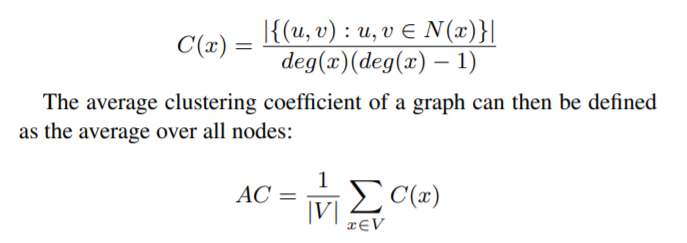

In [167]:
fig = px.line(a, x="Date", y="AVG_COEF")
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
              yaxis_showgrid=False,width=900, height=600,
              title='Avearge Coefficient')

In [30]:
data[data['month']==8]['감염유형'].value_counts()

BigGroup      1612
SmallGroup     168
Personal         6
Name: 감염유형, dtype: int64

In [62]:
a.apply(lambda x : max(x))
b.apply(lambda x : max(x))
a[a['Degree']==9]['Node']
b[b['Degree']==55]['Node']

Node              9696
Degree              12
Closness      0.333333
Betweeness    0.104762
Pagerank       0.16363
dtype: object

Node          10632
Degree            1
Closness          1
Betweeness        0
Pagerank        0.5
dtype: object

Series([], Name: Node, dtype: object)

Series([], Name: Node, dtype: object)